# TISSUE Weighted Principal Component Analysis for downstream clustering and visualization

As an alternative to the TISSUE cell filtering approach, this notebook contains experiments for TISSUE-WPCA, which provides an uncertainty-based weighting of cell-gene expression predictions to obtain principal components, which are then used in downstream tasks.

It relies on the outputs of `spatial_conformal_uncertainty.py` followed by `get_calibration.py` applied to all eleven benchmark dataset pairs. In particular, it requires running the Python commands in all the job scripts of form: `run_conformal_{i}.slurm`. The h5ad anndata objects should be saved into "scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/" with respect to the current working directory (or an alternative path for stratified grouping results).

It also requires simulated data files generated by `00_generate_srtsim_data.R` followed by `00_format_srtsim_data.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.manifold import TSNE
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal

from wpca import PCA, WPCA, EMPCA

from TISSUE.tissue.main import *
from TISSUE.tissue.downstream import *
from TISSUE.tissue.experiments import *
from TISSUE.tissue.utils import *

from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import ttest_rel
from sklearn.cluster import KMeans
from sklearn.svm import SVC

## Simulation/synthetic data generation

Same as the function used in the `04_TISSUE_filtering_for_downstream_simulated_data.ipynb`

In [2]:
def simulate_data_fromfile (dataset_name, sigma_imputation=0.1, mixing=0.2, prop_biased=0.9, random_state=None, mixin_setup=["A","B"]):
    '''
    Creates data for simulation of imputation bias between conditions
    
    "condition" must be a column in the Metadata.txt file and contain "A" and "B" only
    '''
    # read in dataset
    adata = load_spatial_data("DataUpload/"+dataset_name+"/Spatial_count.txt",
                              "DataUpload/"+dataset_name+"/Locations.txt",
                              "DataUpload/"+dataset_name+"/Metadata.txt")
    
    # subset to overexpression fold changes
    adata = adata[:,[x for x in adata.var_names if int(x.split("noise")[-1].split("signal")[-1])<=round(adata.shape[1]/3)]]
    
    # prediction simulation with added bias
    measured = np.array(adata.X.copy())
    imputed = np.empty_like(measured)
    A_idxs = list(np.where(adata.obs["condition"] == mixin_setup[0])[0])
    B_idxs = list(np.where(adata.obs["condition"] == mixin_setup[1])[0])
    if random_state is not None:
        np.random.seed(random_state)
    bias_idxs = list(np.random.choice(np.arange(adata.shape[1]), size=round(adata.shape[1]*prop_biased), replace=False))
    nobias_idxs = [i for i in range(adata.shape[1]) if i not in bias_idxs]
    
    # impute one half consistently with zero-centered Gaussian noise
    if random_state is not None:
        np.random.seed(random_state)
    imputed[:,nobias_idxs] = measured[:,nobias_idxs] + np.random.normal(0,sigma_imputation,(imputed.shape[0],len(nobias_idxs)))
    
    # impute other half with bias of mu offset for one group
    n_mix = round(mixing*len(B_idxs))
    if random_state is not None:
        np.random.seed(random_state)
    random_idxs = np.random.choice(B_idxs,n_mix,replace=False)
    other_idxs = [i for i in range(adata.shape[0]) if i not in random_idxs]
    
    # construct bias offset based on sampling from group A
    mix_in_noise_mat = np.zeros((n_mix,len(bias_idxs)))
    for mxi, bi in enumerate(bias_idxs):
        gene = adata.var_names[bi]
        if random_state is not None:
            np.random.seed(random_state)
        mixin_draws = np.random.choice(adata[adata.obs.condition==mixin_setup[0],gene].X.flatten(), n_mix, replace=True)
        if random_state is not None:
            np.random.seed(random_state)
        mix_in_noise_mat[:,mxi] = (mixin_draws-adata[:,gene].X[random_idxs].flatten()) + np.random.normal(0,sigma_imputation,n_mix)
    
    imputed[np.ix_(random_idxs,bias_idxs)] = measured[np.ix_(random_idxs,bias_idxs)] + mix_in_noise_mat
    if random_state is not None:
        np.random.seed(random_state)
    imputed[np.ix_(other_idxs,bias_idxs)] = measured[np.ix_(other_idxs,bias_idxs)] + np.random.normal(0,sigma_imputation,
                                                      (adata.shape[0]-n_mix,len(bias_idxs)))
    
    # create adata
    adata.obsm["sim_predicted_expression"] = pd.DataFrame(imputed, columns=adata.var_names, index=adata.obs_names)
    
    
    # get calib genes (50%)
    calib_genes=np.random.choice(adata.var_names,round(adata.shape[1]/2),replace=False)
    
    labels = np.array([0 if x==mixin_setup[0] else 1 for x in adata.obs["condition"]])
    
    return (adata, calib_genes, labels)

## Running evaluation of TISSUE-WPCA improvements in downstream tasks

There are two commented blocks that can be toggled on and off to switch between the binarized weighting scheme and a less ad hoc scheme that only uses the log transformation.

In [ ]:
# set up parameters
n_components=15
mix_props = np.linspace(0,1,20)


# set up dictionary for results
mix_dict = {}
for key in ["measured", "imputed", "piwidth", "residual"]:
    mix_dict[key] = {}
    mix_dict[key]["mean_svm_linear_acc"] = []
    mix_dict[key]["range_svm_linear_acc"] = []


for mix in mix_props:
    
    measured_acc = []
    imputed_acc = []
    imputed_weighted_piwidth_acc = []
    imputed_weighted_residual_acc = []
    
    for i in range(20):
    
        adata, calib_genes, labels = simulate_data_fromfile('SRTsim_main_two_conditions_different', mixing=mix, prop_biased=1.0, mixin_setup=["B","A"])
        true_clusters = labels

        # build spatial graph
        build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)

        # conformalize
        conformalize_spatial_uncertainty(adata, "sim_predicted_expression", calib_genes, weight="exp_cos", mean_normalized=False,
                                         grouping_method="kmeans_gene_cell", k='auto', k2='auto', n_pc=15)

        # get PI's
        conformalize_prediction_interval(adata, "sim_predicted_expression", calib_genes, alpha_level=0.33)

        # run PCA
        X_red = adata.X
        X_red = StandardScaler().fit_transform(X_red)
        X_red = WPCA(n_components=n_components).fit_transform(X_red)
        
        # Unweighted
        weighted_PCA(adata, "sim", pca_method="wpca", weighting="uniform",
                     n_components=n_components, tag="unweighted", scale=True)
        X_red_imp = adata.obsm['sim_predicted_expression_PC15_unweighted']
        
        # Weighted
#         w = weighted_PCA(adata, "sim", pca_method="wpca", weighting="inverse_norm_pi_width",
#                          binarize=0.2, binarize_ratio=10, quantile_cutoff=None, log_transform=False,
#                          n_components=n_components, tag="weighted", replace_inf="max", scale=True, return_weights=True)
#         X_red_imp_weighted = adata.obsm['sim_predicted_expression_PC15_weighted']
        w = weighted_PCA(adata, "sim", pca_method="wpca", weighting="inverse_norm_pi_width",
                         binarize=False, quantile_cutoff=None, log_transform=True,
                         n_components=n_components, tag="weighted", replace_inf="mean", scale=True, return_weights=True)
        X_red_imp_weighted = adata.obsm['sim_predicted_expression_PC15_weighted']
        
        # Weighted-Residual
#         w = weighted_PCA(adata, "sim", pca_method="wpca", weighting="inverse_norm_residual",
#                          binarize=0.2, binarize_ratio=10, quantile_cutoff=None, log_transform=False,
#                          n_components=n_components, tag="weighted_res", replace_inf="max", scale=True, return_weights=True)
#         X_red_imp_weighted_res = adata.obsm['sim_predicted_expression_PC15_weighted_res']
        w = weighted_PCA(adata, "sim", pca_method="wpca", weighting="inverse_norm_residual",
                         binarize=False, quantile_cutoff=None, log_transform=True,
                         n_components=n_components, tag="weighted_res", replace_inf="mean", scale=True, return_weights=True)
        X_red_imp_weighted_res = adata.obsm['sim_predicted_expression_PC15_weighted_res']

        # Linear separability with SVC
        clf = SVC(kernel='linear', random_state=444).fit(X_red, true_clusters)
        measured_acc.append(clf.score(X_red, true_clusters))

        clf = SVC(kernel='linear', random_state=444).fit(X_red_imp, true_clusters)
        imputed_acc.append(clf.score(X_red_imp, true_clusters))

        clf = SVC(kernel='linear', random_state=444).fit(X_red_imp_weighted, true_clusters)
        imputed_weighted_piwidth_acc.append(clf.score(X_red_imp_weighted, true_clusters))
        
        clf = SVC(kernel='linear', random_state=444).fit(X_red_imp_weighted_res, true_clusters)
        imputed_weighted_residual_acc.append(clf.score(X_red_imp_weighted_res, true_clusters))
        
    # append results
    mix_dict["measured"]["mean_svm_linear_acc"].append(np.nanmean(measured_acc))
    mix_dict["imputed"]["mean_svm_linear_acc"].append(np.nanmean(imputed_acc))
    mix_dict["piwidth"]["mean_svm_linear_acc"].append(np.nanmean(imputed_weighted_piwidth_acc))
    mix_dict["residual"]["mean_svm_linear_acc"].append(np.nanmean(imputed_weighted_residual_acc))
    
    mix_dict["measured"]["range_svm_linear_acc"].append((np.nanquantile(measured_acc,0.25),(np.nanquantile(measured_acc,0.75))))
    mix_dict["imputed"]["range_svm_linear_acc"].append((np.nanquantile(imputed_acc,0.25),(np.nanquantile(imputed_acc,0.75))))
    mix_dict["piwidth"]["range_svm_linear_acc"].append((np.nanquantile(imputed_weighted_piwidth_acc,0.25),(np.nanquantile(imputed_weighted_piwidth_acc,0.75))))
    mix_dict["residual"]["range_svm_linear_acc"].append((np.nanquantile(imputed_weighted_residual_acc,0.25),(np.nanquantile(imputed_weighted_residual_acc,0.75))))

In [8]:
# pickle dict

# with open(f"results/clustering/REVISED_simulated_mix_0_1_20_default_params_10rep_FINAL_nobin_invnorm_SRTsim.pkl", "wb") as f:
#     pickle.dump(mix_dict, f)

# with open(f"results/clustering/REVISED_simulated_mix_0_1_20_default_params_20rep_FINAL_bin020_invnorm_SRTsim.pkl", "wb") as f:
#     pickle.dump(mix_dict, f)

### Generating plots from results

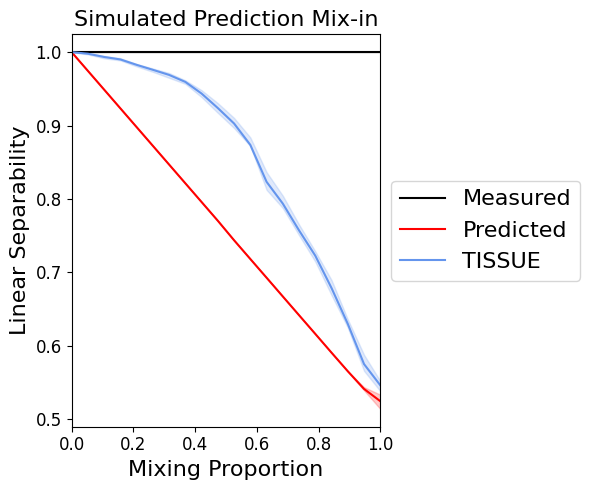

In [3]:
filename = "REVISED_simulated_mix_0_1_20_default_params_10rep_FINAL_nobin_invnorm_SRTsim"
mix_props = np.linspace(0,1,20)
start = 0

########################################
with open(f"results/clustering/{filename}.pkl", "rb") as f:
    mix_dict = pickle.load(f)

plt.figure(figsize=(6,5))

# plot medians
plt.plot(mix_props[start:], mix_dict["measured"]["mean_svm_linear_acc"][start:], label="Measured", color="k")
plt.plot(mix_props[start:], mix_dict["imputed"]["mean_svm_linear_acc"][start:], label="Predicted", color="r")
plt.plot(mix_props[start:], mix_dict["piwidth"]["mean_svm_linear_acc"][start:], label="TISSUE", color="cornflowerblue")

# plot ranges
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["measured"]["range_svm_linear_acc"]][start:],
                 [x[1] for x in mix_dict["measured"]["range_svm_linear_acc"]][start:], color="k", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed"]["range_svm_linear_acc"]][start:],
                 [x[1] for x in mix_dict["imputed"]["range_svm_linear_acc"]][start:], color="r", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["piwidth"]["range_svm_linear_acc"]][start:],
                 [x[1] for x in mix_dict["piwidth"]["range_svm_linear_acc"]][start:], color="cornflowerblue", alpha=0.2)

# annotate plot
plt.title("Simulated Prediction Mix-in", fontsize=16)
plt.xlabel(r"Mixing Proportion", fontsize=16)
plt.ylabel("Linear Separability", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
plt.xlim(np.min(mix_props[start:]),np.max(mix_props[start:]))
plt.tight_layout()
plt.savefig(f"plots/scpi_clustering/{filename}_linear_separability.pdf", bbox_inches="tight")
plt.show()

### TISSUE-WPCA on real spatial transcriptomic datasets

Requires the outputs from `spatial_conformal_uncertainty.py` followed by `get_calibration.py` (see notebook header for parameter details).

In [2]:
dirnames = ["2023Aug1_k4k1_SDbasedCCPplus1"]
dataset_names = ["Dataset3", "Dataset13", "Dataset15", "Dataset15", "Dataset1", "Axolotl"]
metadata_labels = ["celltype", "celltype_lowres", "Region", "ClusterName", "celltype_mapped_refined", "Annotation"]
methods = ['knn', 'spage', 'tangram']
n_classes = 3
n_components = 15

######################################


df_dict = {}
df_dict["Dataset"] = []
df_dict["Imputation Method"] = []
df_dict["PCA"] = []
df_dict["Adjusted Rand Index"] = []
df_dict["Directory"] = []


for dirname in dirnames:
    for di, d in enumerate(dataset_names):
        
        # read in data results
        if os.path.isfile(f'scg_results/scpi/{dirname}/{d}_knn_spage_tangram_SCPI.h5ad'):
            adata = sc.read_h5ad(f'scg_results/scpi/{dirname}/{d}_knn_spage_tangram_SCPI.h5ad')
        else:
            adata = large_load(f'scg_results/scpi/{dirname}/{d}_knn_spage_tangram_SCPI')
        
        # get label key
        label = metadata_labels[di]
        
        # subset into observations falling into most prevalent classes (if specified)
        uniq_labels, counts = np.unique(adata.obs[label], return_counts=True)
        if len(uniq_labels) > n_classes:
            sorted_uniq_labels = uniq_labels[np.argsort(counts)][::-1][:n_classes]
            adata = adata[adata.obs[label].isin(sorted_uniq_labels)]
        
        ### PCA ###

        # Get ground truth clustering
        true_clusters = adata.obs[label]
        
        # Get imputation PCA + clustering and compute quality metrics
        for m in methods:

            adata.obsm[f'{m}_predicted_expression_hi'] = adata.obsm[f'{m}_predicted_expression_hi_67']
            adata.obsm[f'{m}_predicted_expression_lo'] = adata.obsm[f'{m}_predicted_expression_lo_67']
            
            # PCA using only imputation (unweighted)
            weighted_PCA(adata, m, pca_method="wpca", weighting="uniform",
                         n_components=n_components, tag="unweighted", scale=True)

            # PCA using uncertainties (weighted)
            w = weighted_PCA(adata, m, pca_method="wpca", weighting="inverse_norm_pi_width",
                             binarize=0.2, binarize_ratio=10, quantile_cutoff=None, log_transform=False,
                             n_components=n_components, tag="weighted", replace_inf="max", scale=True, return_weights=True)
            
            # Clustering using only imputation (unweighted)
            X_red_imp = adata.obsm[f"{m}_predicted_expression_PC{n_components}_unweighted"]
            kmeans = KMeans(n_clusters=n_classes).fit(X_red_imp)
            imp_clusters = kmeans.labels_.copy()

            # Clustering using uncertainties (weighted)
            X_red_imp = adata.obsm[f"{m}_predicted_expression_PC{n_components}_weighted"]
            kmeans = KMeans(n_clusters=n_classes).fit(X_red_imp)
            imp_clusters_weighted = kmeans.labels_.copy()
            
            # Compare to original and compute metrics
            unweighted_ri = adjusted_rand_score(true_clusters, imp_clusters)
            weighted_ri = adjusted_rand_score(true_clusters, imp_clusters_weighted)
            
            # Append results to dictionary
            df_dict["Dataset"] += [d,d]
            df_dict["Directory"] += [dirname, dirname]
            df_dict["Imputation Method"] += [m,m]
            df_dict["PCA"] += ["unweighted", "weighted"]
            df_dict["Adjusted Rand Index"] += [unweighted_ri, weighted_ri]

df = pd.DataFrame(df_dict)

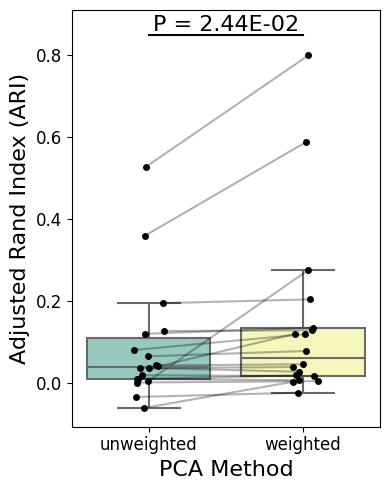

-0.05576069016553582


Ttest_relResult(statistic=-2.469009302722284, pvalue=0.024447791118986005)

In [3]:
sub_df = df.copy()
fig, ax = plt.subplots(figsize=(4,5))

sns.stripplot(data=sub_df, x="PCA", y="Adjusted Rand Index", c='k')
sns.boxplot(data=sub_df, x="PCA", y="Adjusted Rand Index", palette="Set3", showfliers=False)

# Draw connecting lines
locs1 = ax.get_children()[0].get_offsets()
locs2 = ax.get_children()[1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)

# statistical annotation
x_coords = [0.5]
y_coords = [0.85]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(sub_df[sub_df["PCA"]=="unweighted"]["Adjusted Rand Index"], sub_df[sub_df["PCA"]=="weighted"]["Adjusted Rand Index"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)

plt.ylim(None, y+0.06)

plt.xlabel("PCA Method", fontsize=16)
plt.ylabel("Adjusted Rand Index (ARI)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/scpi_clustering/REVISED_WPCA_SDcc_020binarized.pdf", bbox_inches="tight")
plt.show()

from scipy.stats import ttest_rel
print(sub_df[sub_df["PCA"]=="unweighted"]["Adjusted Rand Index"].mean()-sub_df[sub_df["PCA"]=="weighted"]["Adjusted Rand Index"].mean())
ttest_rel(sub_df[sub_df["PCA"]=="unweighted"]["Adjusted Rand Index"], sub_df[sub_df["PCA"]=="weighted"]["Adjusted Rand Index"])